# Notebook Setup
Installs necessary requirements and configures proper notebook behavior  
Note: The notebook assumes you are using the base conda environment

In [59]:
%load_ext autoreload
%autoreload 2
# !python -m pip install -r requirements.txt
    
print("Notebook setup has completed")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Notebook setup has completed


# Download Data
Specify which datasets to use and download

In [72]:
from bootstrap import download_data_file
from preprocessing import  CDS_AND_VINYL_JSON_PARAMS, CELL_PHONE_JSON_PARAMS
DATASETS = [ CDS_AND_VINYL_JSON_PARAMS, CELL_PHONE_JSON_PARAMS]

URL_SOURCE = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/"
for dataset in DATASETS:
    download_data_file(URL_SOURCE, dataset['file'])

File C:\Users\matth\Documents\Homework\COMP5630\ML-Project\data\CDs_and_Vinyl_5.json.gz already exists, skipping download


# Load Data Into Memory
Load the data from the gzipped json file into a pandas dataframe

In [73]:
from preprocessing import get_dataframe_file
import pandas as pd
POINTS_PER_FILE = 50_000
frames = []
for dataset in DATASETS:
    frame = get_dataframe_file(params = dataset, points=POINTS_PER_FILE, equalize=True)
    frame.dropna(inplace=True)
    frames.append(frame)
df = pd.concat(frames)

# Format Data
Split into training, testing, and validation sets, and transform text into a format that can be used by the model

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import get_subsets

word_vectorizer = CountVectorizer(
    min_df=0.0001, 
    max_df=0.7
 )
X = df["reviewText"].to_numpy()
X = word_vectorizer.fit_transform(X)
y = df['overall'].to_numpy()

X_train, X_val, X_test, y_train, y_val, y_test = get_subsets(X,y, train_split=0.8, val_split=0.1, test_split=0.1)
print(f"X_train: {X_train.shape}\t y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\t y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\t y_test: {y_test.shape}")


X_train: (16032, 16188)	 y_train: (16032,)
X_val: (2004, 16188)	 y_val: (2004,)
X_test: (2005, 16188)	 y_test: (2005,)


# Visualize Data Distribution

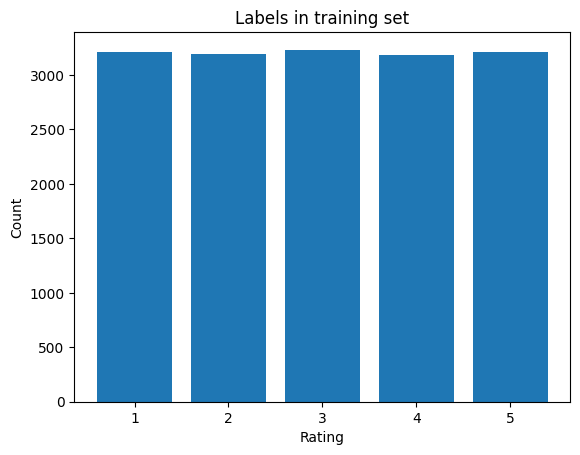

Label mean:  3.000436626746507
Label Standard Deviation:  1.414456056970875


In [83]:
import matplotlib.pyplot as plt
import numpy as np
categories, counts = np.unique(y_train, return_counts=True)
plt.bar(categories, counts)
plt.title("Labels in training set")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()
print("Label mean: ", np.mean(y_train))
print("Label Standard Deviation: ", np.std(y_train))

# Training the Model

In [111]:
from mlp import MultiLayerPerceptron
our_mlp = MultiLayerPerceptron(
    epochs=10,
    lr=0.05,
    hidden_layers=[50, 20],
    activation="sigmoid",
)
our_mlp.fit(X_train, y_train, X_val, y_val, batch_size=500)
# clf.plot_loss()

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


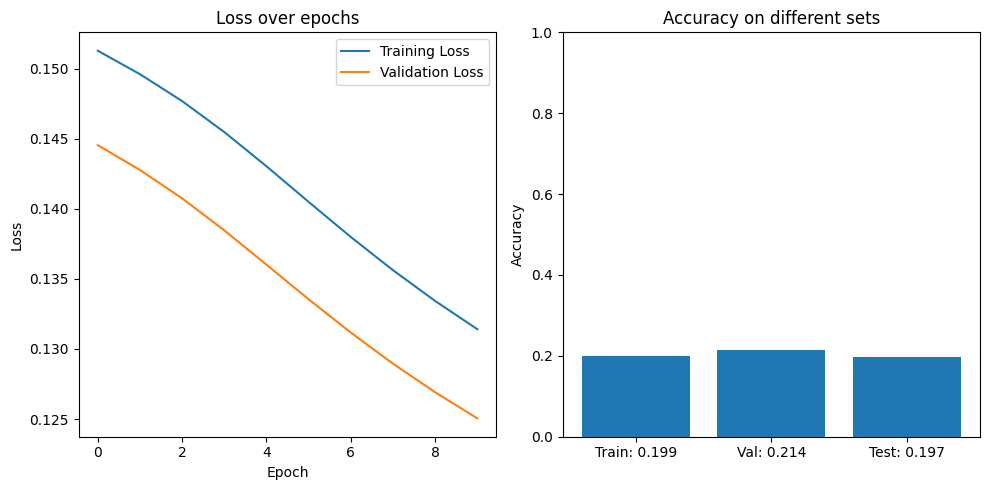

In [123]:
training_score = our_mlp.score(X_train, y_train)
validation_score = our_mlp.score(X_val, y_val)
test_score = our_mlp.score(X_test, y_test)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(our_mlp.train_loss_curve, label="Training Loss")
ax1.plot(our_mlp.val_loss_curve, label="Validation Loss")
ax1.set_title("Loss over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
ax2.set_title("Accuracy on different sets")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

fig.tight_layout()

In [113]:
from sklearn.metrics import classification_report

y_pred = our_mlp.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           1       0.14      0.00      0.01       392
           2       0.20      0.86      0.32       405
           3       0.14      0.01      0.03       408
           4       0.20      0.09      0.13       403
           5       0.00      0.00      0.00       397

    accuracy                           0.20      2005
   macro avg       0.14      0.20      0.10      2005
weighted avg       0.14      0.20      0.10      2005



# Benchmarking

In [129]:
from sklearn.neural_network import MLPClassifier
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(50, 20),
    activation="logistic",
    max_iter=25,
    learning_rate_init=0.05,
    learning_rate="constant",
    solver="sgd",
    batch_size=200,
    nesterovs_momentum=False,
    alpha=0,
    power_t=1,
    shuffle=False
)
sklearn_mlp = sklearn_mlp.fit(X_train, y_train)

c:\Users\matth\Documents\Homework\COMP5630\ML-Project\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


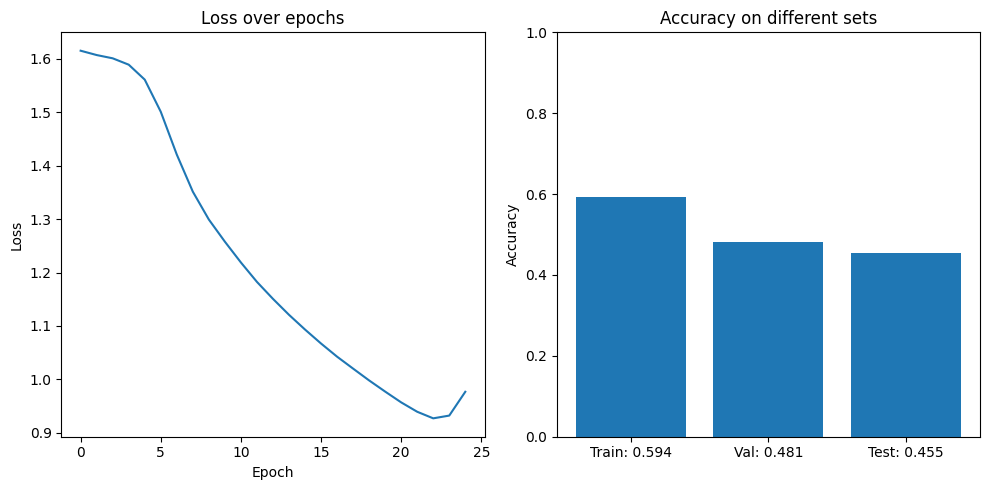

In [130]:
training_score = sklearn_mlp.score(X_train, y_train)
validation_score = sklearn_mlp.score(X_val, y_val)
test_score = sklearn_mlp.score(X_test, y_test)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(sklearn_mlp.loss_curve_)
ax1.set_title("Loss over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
ax2.set_title("Accuracy on different sets")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

fig.tight_layout()

In [116]:
from sklearn.metrics import classification_report

y_pred = sklearn_mlp.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           1       0.51      0.62      0.56       392
           2       0.34      0.30      0.32       405
           3       0.37      0.22      0.28       408
           4       0.37      0.32      0.34       403
           5       0.50      0.72      0.59       397

    accuracy                           0.43      2005
   macro avg       0.42      0.44      0.42      2005
weighted avg       0.42      0.43      0.41      2005



In [131]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300)

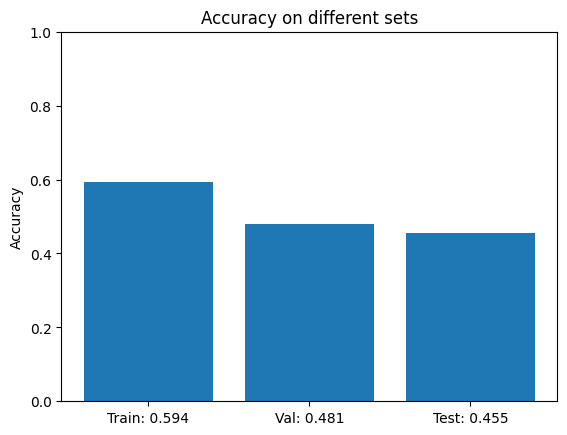

In [132]:
training_score = sklearn_mlp.score(X_train, y_train)
validation_score = sklearn_mlp.score(X_val, y_val)
test_score = sklearn_mlp.score(X_test, y_test)
plt.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
plt.title("Accuracy on different sets")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

# Training

In [ ]:
from sympy import Lambda, Symbol
from training import matrix_train


x = Symbol("x")


# each axis must be an iterable. if you want to use a constant, wrap it in an iterable of len 1
hyperparameter_matrix = {
    "epochs": np.logspace(np.log10(100), np.log10(100000), num=20, dtype="int64"),
    "lr": np.logspace(np.log10(.00001), np.log10(.1), num=20),
    "hidden_layers": [5, 6, 7],
    "neurons_per_layer": [3],
    "activation": [Lambda(x, x**2)],
}

best_params = matrix_train(hyperparameter_matrix, MultiLayerPerceptron, X_train, y_train, X_test, y_test)

print(best_params)
# mlp = MultiLayerPerceptron(**best_params)


# Performance

In [ ]:
from analysis import accuracy, confusion, report


mlp = MultiLayerPerceptron(**best_params)
mlp.fit(X_train, y_train)

# print(accuracy(mlp.predict(X_test), y_test))
# print(confusion(mlp.predict(X_test), y_test))
print(report(mlp.predict(X_test), y_test))


# Benchmarking

In [ ]:
# TODO utilize other classifiers and compare performance